<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
How to aggregate daily NASA MODIS active fires using python ? 
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

In [10]:
from calendar import monthrange
from matplotlib.pyplot import figure
from pylab import matplotlib
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *

import numpy as np
import numpy.ma as ma
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.cm as cm
import warnings


warnings.filterwarnings('ignore')

In [11]:
root = '/Volumes/HD2/Datasets/Research'

In [12]:
year = 2019
month = 8
day = 1

In [13]:
platform = 'AQUA'
instrument = 'MODIS'
product = 'MYD14'

MODIS_Files = glob.glob('{}/NASA/{}/{}/{}/{:04d}/{:04d}_{:02d}_{:02d}/*.hdf'.format(
    root,
    platform,
    instrument,
    product,
    year,
    year,
    month,
    day))

print( len(MODIS_Files) )

288


In [21]:
%%time

df = pd.DataFrame()

for idx,MODIS_File in enumerate(MODIS_Files):
                    
    df_new = pd.DataFrame()
    
    f = SD(MODIS_File, SDC.READ)
    
    sds_obj = f.select('fire mask') # select sds

    fm_data = sds_obj.get() # get sds data
    
    if fm_data[ fm_data > 6 ].shape[0] > 0:
    
        for key in ['FP_latitude', 
                     'FP_longitude', 
                     'FP_ViewZenAng',
                     'FP_power']:

            sds_obj = f.select(key) # select sds
            
            data = sds_obj.get() # get sds data

            df_new[key] = data.ravel()   
        
        df = pd.concat([df,df_new], axis=0)  
    
    f.end()

CPU times: user 2.47 s, sys: 275 ms, total: 2.74 s
Wall time: 5.77 s


In [22]:
df

,FP_latitude,FP_longitude,FP_ViewZenAng,FP_power
0,-0.382027,-159.996246,35.930000,11.264409
0,52.153366,10.410227,38.099998,17.696375
1,48.605171,21.183517,29.230000,9.364980
2,48.283260,14.334062,11.040000,7.563391
3,45.151867,9.948322,31.099998,10.447313
...,...,...,...,...
4,-16.453432,29.001038,60.359997,33.806599
5,-16.459944,28.992243,60.359997,35.177670
6,-26.703041,28.370163,51.340000,29.420910
7,-26.696156,28.364603,51.340000,26.542192


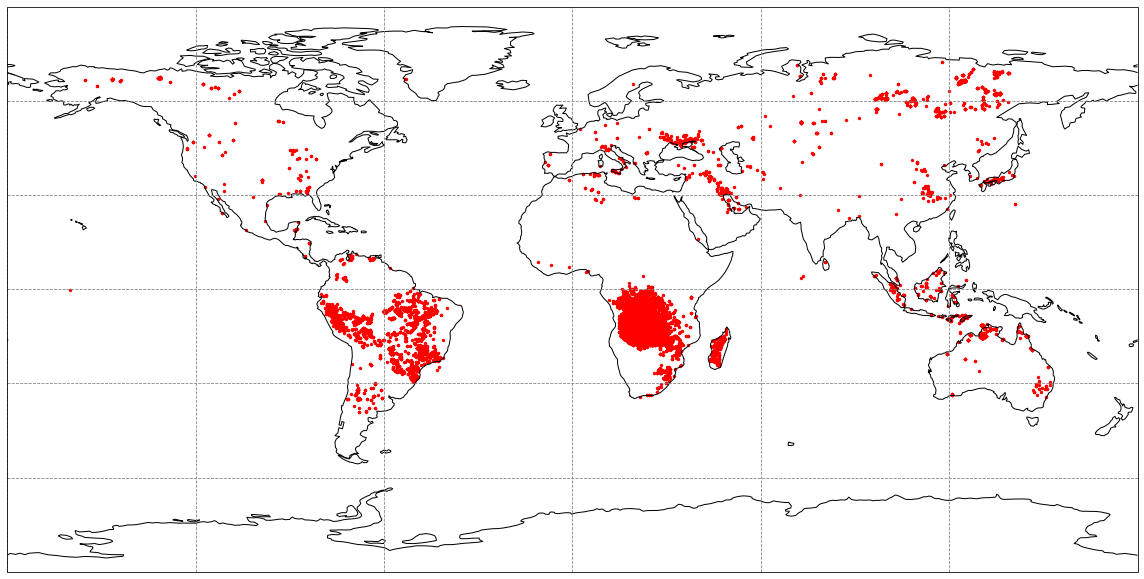

In [23]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

longs = df['FP_longitude']
lats = df['FP_latitude']

plt.scatter( longs, lats,
         color='red', linewidth=2, marker='o', s=2,
         transform=ccrs.PlateCarree(),
         )

#plt.title('({}) VIIRS AF IBands {}-{}-{} / FP_PersistentAnomalyCategory = {} ({})'.format(platform,year,month,day,PersistentAnomalyCategory,FP_PersistentAnomalyCategory_Legend[PersistentAnomalyCategory]),fontsize=16)

plt.tight_layout()

#plt.savefig('./outputs/{}_AF_Iband_PAC_{}_2022_07_08.png'.format(platform,PersistentAnomalyCategory), dpi=150, facecolor='white')

plt.show()

plt.close()

In [24]:
resolution = 0.5

In [25]:
def quantitative_to_categorical_converter(x,col1,col2,resolution):
    lat_idx = int( (x[col1]+90.0) / resolution )
    long_idx = int( (x[col2]+180) / resolution )
    return int( 360 / resolution ) * lat_idx + long_idx

In [26]:
%%time

df['Index'] = df.apply(quantitative_to_categorical_converter, 
                       axis=1, 
                       col1 = 'FP_latitude',
                       col2 = 'FP_longitude',
                       resolution=resolution)

df[ ['Index', 'FP_latitude', 'FP_longitude'] ]

CPU times: user 217 ms, sys: 6.55 ms, total: 223 ms
Wall time: 227 ms


,Index,FP_latitude,FP_longitude
0,128920,-0.382027,-159.996246
0,204860,52.153366,10.410227
1,199842,48.605171,21.183517
2,199108,48.283260,14.334062
3,194779,45.151867,9.948322
...,...,...,...
4,106258,-16.453432,29.001038
5,106257,-16.459944,28.992243
6,91136,-26.703041,28.370163
7,91136,-26.696156,28.364603


In [27]:
dfg = df[['Index','FP_power']].groupby(['Index']).sum()

dfg

,FP_power
Index,
72948,18.642422
73664,27.649620
73668,15.627724
75104,4.048640
75110,45.650467
...,...
229597,80.354446
231014,112.464722
231015,13.702325


In [33]:
dfg = dfg.reset_index()

dfg

,Index,FP_power
0,72948,18.642422
1,73664,27.649620
2,73668,15.627724
3,75104,4.048640
4,75110,45.650467
...,...,...
2562,229597,80.354446
2563,231014,112.464722
2564,231015,13.702325
2565,232342,25.499838


In [28]:
data = np.zeros(( int(180 / resolution) , int(360 / resolution) ))

shape = data.shape

print(data.shape)
print(data.size)

(360, 720)
259200


In [29]:
df_map = pd.DataFrame()

xv, yv = np.meshgrid(np.arange( -90,90, resolution), np.arange(-180,180,resolution))

df_map['latitude'] = xv.ravel()
df_map['longitude'] = yv.ravel()

df_map

,latitude,longitude
0,-90.0,-180.0
1,-89.5,-180.0
2,-89.0,-180.0
3,-88.5,-180.0
4,-88.0,-180.0
...,...,...
259195,87.5,179.5
259196,88.0,179.5
259197,88.5,179.5
259198,89.0,179.5


In [30]:
%%time

df_map['Index'] = df_map.apply(quantitative_to_categorical_converter, 
                       axis=1, 
                       col1 = 'latitude',
                       col2 = 'longitude',
                       resolution=resolution)

CPU times: user 2.17 s, sys: 31.2 ms, total: 2.21 s
Wall time: 2.22 s


In [31]:
df_map

,latitude,longitude,Index
0,-90.0,-180.0,0
1,-89.5,-180.0,720
2,-89.0,-180.0,1440
3,-88.5,-180.0,2160
4,-88.0,-180.0,2880
...,...,...,...
259195,87.5,179.5,256319
259196,88.0,179.5,257039
259197,88.5,179.5,257759
259198,89.0,179.5,258479


In [34]:
df_merged = pd.merge(dfg,df_map, on=['Index'], how='right')

df_merged

,Index,FP_power,latitude,longitude
0,0,NaN,-90.0,-180.0
1,720,NaN,-89.5,-180.0
2,1440,NaN,-89.0,-180.0
3,2160,NaN,-88.5,-180.0
4,2880,NaN,-88.0,-180.0
...,...,...,...,...
259195,256319,NaN,87.5,179.5
259196,257039,NaN,88.0,179.5
259197,257759,NaN,88.5,179.5
259198,258479,NaN,89.0,179.5


In [35]:
df_merged[ df_merged['FP_power'] > 0 ]

,Index,FP_power,latitude,longitude
14579,128920,11.264409,-0.5,-160.0
17953,225409,17.904938,66.5,-155.5
20829,222537,95.499748,64.5,-151.5
24073,225426,45.140518,66.5,-147.0
24074,226146,268.902252,67.0,-147.0
...,...,...,...,...
238078,85621,11.027405,-31.0,150.5
238436,84182,34.544926,-32.0,151.0
238450,94262,65.415787,-25.0,151.0
239159,86344,6.454925,-30.5,152.0


In [36]:
data = df_merged['FP_power'].to_numpy()
#data = data.reshape(180, 360)
data = data.reshape(shape[1],shape[0])

In [37]:
data = np.nan_to_num(data)

In [57]:
cmap = cm.get_cmap('hot', 100)   
#cmap = cm.get_cmap('jet', 100)   

color_list = ['#808080']
#color_list = ['#FFFFFF']


for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(matplotlib.colors.rgb2hex(rgba))
    color_list.append(matplotlib.colors.rgb2hex(rgba))
    
cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)

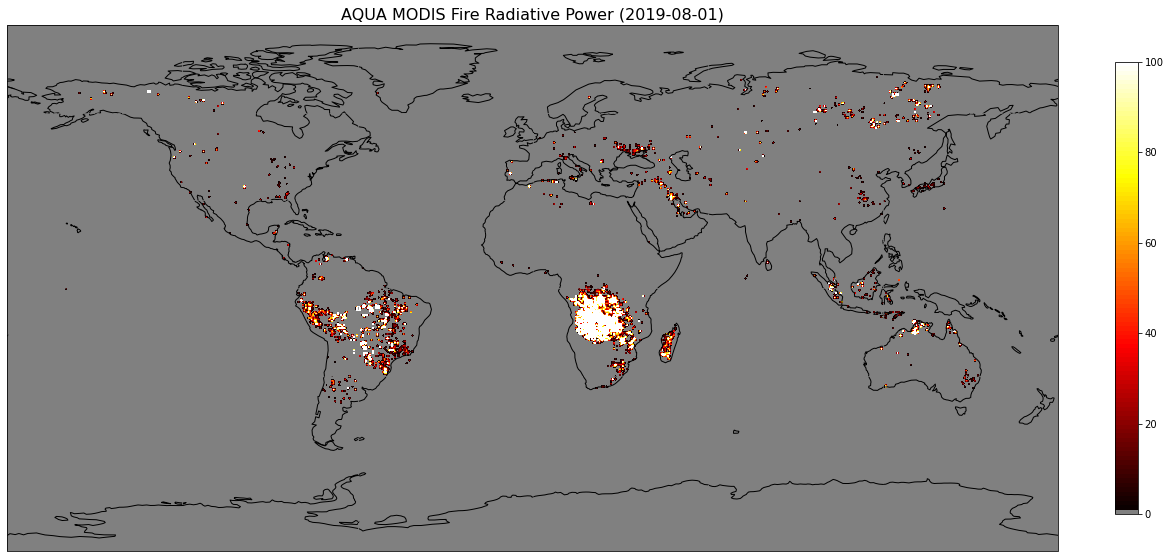

In [70]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

m = ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap=cmap,vmin=0, vmax=100.0)


plt.title('AQUA MODIS Fire Radiative Power (2019-08-01)',fontsize=16)

plt.tight_layout()

plt.colorbar(m,ax=ax, fraction=0.02)

plt.savefig("./outputs/Fire_Radiative_Power_Map.png", bbox_inches='tight', dpi=200, facecolor='white')

plt.show()

plt.close()